In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import glob
import sys
import copy
import cv2
import numba
from imp import reload
from scipy.optimize import curve_fit
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

In [2]:
nPosts = 3
spatial_discretisation_step = 0.01

dataDIR = '/mnt/ssd1/Documents/Vivek/locustVR/data/'
projectDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustProjects_2_3post-june.db'
expDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustExperiments_2_3post-june.db'

In [3]:
def rotate(xy, radians):
    x, y = xy
    c, s = np.cos(radians), np.sin(radians)
    j = np.matrix([[c, s], [-s, c]])
    m = np.dot(j, [x, y])

    return m

In [4]:
# establish a connecttion to the project database
conn = sqlite3.connect(projectDB)
# connect a cursor that goes through the project database
cursorProject = conn.cursor()
# establish a second connecttion to the experiment database
conn2 = sqlite3.connect(expDB)
# connect a cursor that goes through the experiment database
cursorExperiment = conn2.cursor()

# pick experiments from specified project
cursorExperiment.execute("Select expId from experiments where project = ? and exp >= ? and exp < ?",('DecisionGeometry', 0, 10))
fetched = cursorExperiment.fetchall()
print('fetched : ' + str(fetched))

fetched : [('2ac1867c-dc2a-42da-9576-8c7a6482b366',), ('41433f98-28ba-450e-89cf-340118383727',), ('470d6365-97f3-47b6-af16-0e0edb63f5c7',), ('44806f65-a52f-40f3-9c1e-bce254fcf3e4',), ('3801ae23-7edc-4d97-a9d0-37cbafd4a77f',), ('b5e408fa-03d4-4cbb-8c18-c7d03a8d331e',), ('c1800e9b-1d24-494c-a99b-0a34238f8446',), ('a44fa020-5b5a-4f82-ab63-8a6bdbdcfc85',), ('d5da8fc7-9c3b-4abe-bdc6-d3af900b495c',), ('b7c6e8c3-aadb-4e26-985e-5085fe24251e',), ('2c4b5bc5-22c9-4380-bd55-61d0e0eee296',), ('7eb9733b-0f64-4129-91e5-9067414b3054',), ('f4aa8f77-23b7-4063-b0e5-ea42e439b122',), ('2a405f3a-5738-4509-ac23-82392565e553',), ('be60edb9-0f62-4768-915c-d04105e00806',), ('194a3278-a370-4832-ad2d-e3d5b2aa4dce',), ('95941512-5a5b-4b66-9819-20042b9b81e3',), ('125d2dde-8289-4db0-8e25-8ae2e9b18b8c',), ('f14a9590-27f1-4625-9824-a9cc52aa9ca6',), ('f8edb6e1-dddf-48b9-bd48-ae5e73602e2b',), ('7f88bffe-2e48-4b27-a121-58b1cadaa86f',), ('b423b4c6-2df5-4351-9a2e-bc6d7e267332',), ('3d8ef1e3-c39d-42b9-923c-f50f2e94507d',), 

In [5]:
angles = []
dataDict0 = []
dataDict1 = []
dataDict2 = []
rot_post0 = []
for uuid in range(0,len(fetched)):
    cursorExperiment.execute("Select exp from experiments where expId = ?", (fetched[uuid][0],))
    fetch_exp = cursorExperiment.fetchall()[0][0]
    cursorExperiment.execute("Select replicate from experiments where expId = ?", (fetched[uuid][0],))
    fetch_rep = cursorExperiment.fetchall()[0][0]

    cursorProject.execute("Select post0 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict0.append(cursorProject.fetchall())
    cursorProject.execute("Select post1 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict1.append(cursorProject.fetchall())
    cursorProject.execute("Select post2 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict2.append(cursorProject.fetchall())

    tmp = pd.read_csv(dataDIR + fetched[uuid][0] + "/results.csv", names = ["x", "y", "z", "event", "t", "nStimuli"])
    tmp['uuid'] = uuid
    tmp['angle'] = np.nan
    tmp['post0_x'] = tmp['post0_y'] = tmp['post1_x'] = tmp['post1_y'] = tmp['post2_x'] = tmp['post2_y'] = np.nan
    
    tmp3 = pd.DataFrame(columns=['index','x','y','z','event','t','nStimuli','uuid','angle','post0_x','post0_y','post1_x','post1_y','selected'])
    for i in np.unique(tmp['nStimuli']):
        for j in np.unique(tmp.loc[tmp['nStimuli'] == i, 'event']):
            tmp2 = tmp.loc[(tmp['nStimuli'] == i) & (tmp['event'] == j),:]
            tmp2 = tmp2.reset_index()
            tmp2['selected'] = 0

            start_x = tmp2.loc[0,'x']
            start_y = tmp2.loc[0,'y']
            for k in range(1,len(tmp2)):
                x = tmp2.loc[k,'x']
                y = tmp2.loc[k,'y']
                dist = np.sqrt((start_x - x) ** 2 + (start_y - y) ** 2)
                if dist > spatial_discretisation_step:
                    tmp2.loc[k,'selected'] = 1
                    start_x = x
                    start_y = y
            tmp3 = tmp3.append(tmp2[tmp2['selected'] == 1])
            
    for a in range(1,4):
        tmp3.loc[tmp3['nStimuli'] == a, 'angle'] = eval(dataDict0[uuid][a][0])['angle']

    df = tmp3 if uuid == 0 else pd.concat([df,tmp3])
    rot_post0.append([eval(dataDict0[uuid][1][0])['distance'], 0.0])

    cursorProject.execute("Select post1 from projects where project = ? and exp >= ? and exp < ?",('DecisionGeometry', 0, 10))
    for a in np.unique(cursorProject.fetchall()):
        if a != 'None' and eval(a)['angle'] not in angles:
            angles.append(eval(a)['angle'])

angles = np.sort(np.array(angles))

/home/user/.local/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
# add post positions to dataframe
nStimuli = np.unique(df['nStimuli'])
for uuid in range(0,len(fetched)):
    for i in range(0,np.max(nStimuli)+1):
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][0]
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][1]
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][0]
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][1]
        if i > 0 and i < np.max(nStimuli):
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post2_x'] = eval(dataDict2[uuid][nStimuli[i]][0])['position'][0]
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post2_y'] = eval(dataDict2[uuid][nStimuli[i]][0])['position'][1]

# # initialise rotation of tracks and posts
df['rotated_x'] = df['rotated_y'] = 0.0
df['rotated_post0_x'] = df['rotated_post0_y'] = df['rotated_post1_x'] = df['rotated_post1_y'] = df['rotated_post2_x'] = df['rotated_post2_y'] = 0.0
df['ang'] = 0.0

In [7]:
# get rotation angle
for uuid in range(0,len(fetched)):
    rot_post0_x = rot_post0[uuid][0]
    rot_post0_y = rot_post0[uuid][1]
    df.loc[df['uuid'] == uuid,'ang'] = np.arctan2(df.loc[df['uuid'] == uuid,'post0_y'], df.loc[df['uuid'] == uuid,'post0_x'])

# rotate tracks and posts (posts are now centred along positive x-axis)
for uuid in range(0,len(fetched)):
    for i in range(0,np.max(nStimuli)+1):
        ang = np.unique(df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'ang'])[0] 
        if i > 0 and i < np.max(nStimuli): 
            ang += np.pi*35/180
        else:
            ang += np.pi*35/360

        rx,ry = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'y'])), ang)
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_x'] = np.squeeze(np.asarray(rx.T))
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_y'] = np.squeeze(np.asarray(ry.T))

        rp0x,rp0y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'])), ang)
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_x'] = np.squeeze(np.asarray(rp0x.T))
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_y'] = np.squeeze(np.asarray(rp0y.T))

        rp1x,rp1y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'])), ang)
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_x'] = np.squeeze(np.asarray(rp1x.T))
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_y'] = np.squeeze(np.asarray(rp1y.T))
        
        rp2x,rp2y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post2_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post2_y'])), ang)
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post2_x'] = np.squeeze(np.asarray(rp2x.T))
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post2_y'] = np.squeeze(np.asarray(rp2y.T))

In [8]:
p0_dist = np.sqrt((df['x'] - df['post0_x'])**2 + (df['y'] - df['post0_y'])**2)
p1_dist = np.sqrt((df['x'] - df['post1_x'])**2 + (df['y'] - df['post1_y'])**2)
p2_dist = np.sqrt((df['x'] - df['post2_x'])**2 + (df['y'] - df['post2_y'])**2)

df['dmin'] = np.nanmin([p0_dist, p1_dist, p2_dist], axis=0)
df['post'] = 0

df.loc[(p2_dist.isnull() == True) & (p1_dist < p0_dist), 'post'] = 1
df.loc[(p2_dist.isnull() != True) & (p1_dist < p0_dist) & (p1_dist < p2_dist), 'post'] = 1
df.loc[(p2_dist.isnull() != True) & (p2_dist < p0_dist) & (p2_dist < p1_dist), 'post'] = 2

In [9]:
tmax = df.loc[:,['uuid', 'nStimuli', 'event', 't']]
tmax = tmax.groupby(['uuid', 'nStimuli', 'event']).max().reset_index()
dmin = df.loc[:,['uuid', 'nStimuli', 'event', 't', 'dmin']]

dists = pd.merge(tmax, dmin, how='left')
dists = dists[dists['dmin'] < 1.]
dists = dists.loc[:,['uuid', 'nStimuli', 'event']]

df = pd.merge(dists, df, how='left')

In [10]:
tmp0 = df[(df['nStimuli'] == 0) | (df['nStimuli'] == 4)]
tmp1 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4)]

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


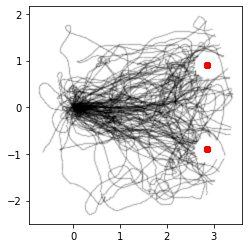

In [11]:
plt.scatter(tmp0['rotated_x'], tmp0['rotated_y'], c='black', s=1, alpha=0.05)
plt.scatter(tmp0['rotated_post0_x'], tmp0['rotated_post0_y'], c='red')
plt.scatter(tmp0['rotated_post1_x'], tmp0['rotated_post1_y'], c='red')
plt.axes().set_aspect('equal')
plt.show()

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


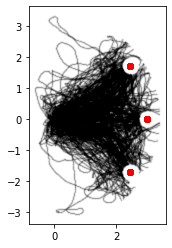

In [12]:
plt.scatter(tmp1['rotated_x'], tmp1['rotated_y'], c='black', s=1, alpha=0.05)
plt.scatter(tmp1['rotated_post0_x'], tmp1['rotated_post0_y'], c='red')
plt.scatter(tmp1['rotated_post1_x'], tmp1['rotated_post1_y'], c='red')
plt.scatter(tmp1['rotated_post2_x'], tmp1['rotated_post2_y'], c='red')
plt.axes().set_aspect('equal')
plt.show()

### Store trajectories from this database as x1s and y1s

In [13]:
if nPosts == 2:
    x1s = np.array(tmp0['rotated_x'])
    y1s = np.array(tmp0['rotated_y'])

    post0_x = np.unique(tmp0['rotated_post0_x'])[0]
    post0_y = np.unique(tmp0['rotated_post0_y'])[0]

    post1_x = np.unique(tmp0['rotated_post1_x'])[0]
    post1_y = np.unique(tmp0['rotated_post1_y'])[0]

else:
    x1s = np.array(tmp1['rotated_x'])
    y1s = np.array(tmp1['rotated_y'])

    post0_x = np.unique(tmp1['rotated_post0_x'])[0]
    post0_y = np.unique(tmp1['rotated_post0_y'])[0]

    post1_x = np.unique(tmp1['rotated_post1_x'])[0]
    post1_y = np.unique(tmp1['rotated_post1_y'])[0]

    post2_x = np.unique(tmp1['rotated_post2_x'])[0]
    post2_y = np.unique(tmp1['rotated_post2_y'])[0]

    x1s = np.concatenate((x1s, x1s))
    y1s = np.concatenate((y1s, -y1s))

### Extract data from second database

In [14]:
projectDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustProjects_2_3post.db'
expDB = '/mnt/ssd1/Documents/Vivek/locustVR/databases/locustExperiments_2_3post.db'

In [15]:
# establish a connecttion to the project database
conn = sqlite3.connect(projectDB)
# connect a cursor that goes through the project database
cursorProject = conn.cursor()
# establish a second connecttion to the experiment database
conn2 = sqlite3.connect(expDB)
# connect a cursor that goes through the experiment database
cursorExperiment = conn2.cursor()

# pick experiments from specified project
cursorExperiment.execute("Select expId from experiments where project = ? and exp >= ? and exp < ?",('DecisionGeometry', 0, 10))
fetched = cursorExperiment.fetchall()
print('fetched : ' + str(fetched))

fetched : [('bf45bd95-2848-4853-906a-02d155ea360f',), ('275a36aa-2130-4973-8f7a-51d342ef37a0',), ('2f93ce1a-6a3d-4f5d-abec-735998285f90',), ('3d4b9226-88d2-445c-9632-8378abb91b6e',), ('343fbf69-b71f-45ea-ba4a-2a2f70e1892c',), ('d41939f0-c81c-47ff-9b47-81ee09e27087',), ('1494b6f9-3e64-4818-8627-d7f1e0b309ff',), ('326cd9a5-e4dd-4a33-8a60-122d7019b004',), ('4a30f1ae-b20b-4d56-b4ca-e5ce89642f27',), ('ea3e490a-0a03-4fdf-ba5d-3368c19f4958',), ('379c93ee-3c34-454c-a61a-1a4e72321092',), ('2b6b14a6-fff9-46ae-a8d4-1503a37cf566',), ('d1b63ac7-fea2-456d-8291-e7831327f749',), ('dde406c4-38c4-4892-898a-69f9d258f300',), ('5f075566-b29a-4dc4-9e1c-28938184a3b8',), ('b01f0694-a031-45e4-8855-e880773b2655',), ('a3978ca8-003f-4c79-9bdf-371db327d752',), ('7963d761-6ac9-494a-9614-fb3d2c495dc9',), ('0f2ca902-3943-45d2-9fa1-22c66c78351d',), ('afde8a2c-96ed-4f96-b808-03cc806491f1',), ('964a88a9-ecbe-42bc-90c0-0906ba83797f',), ('b9b8e1a5-c1bc-4cc8-ac24-69b944d09cf7',), ('a80709fd-bc85-4933-adab-ca6009a2219f',), 

In [16]:
angles = []
dataDict0 = []
dataDict1 = []
dataDict2 = []
rot_post0 = []
for uuid in range(0,len(fetched)):
    cursorExperiment.execute("Select exp from experiments where expId = ?", (fetched[uuid][0],))
    fetch_exp = cursorExperiment.fetchall()[0][0]
    cursorExperiment.execute("Select replicate from experiments where expId = ?", (fetched[uuid][0],))
    fetch_rep = cursorExperiment.fetchall()[0][0]

    cursorProject.execute("Select post0 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict0.append(cursorProject.fetchall())
    cursorProject.execute("Select post1 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict1.append(cursorProject.fetchall())
    cursorProject.execute("Select post2 from projects where project = ? and exp = ? and replicate = ?",('DecisionGeometry', fetch_exp, fetch_rep))
    dataDict2.append(cursorProject.fetchall())

    tmp = pd.read_csv(dataDIR + fetched[uuid][0] + "/results.csv", names = ["x", "y", "z", "event", "t", "nStimuli"])
    tmp['uuid'] = uuid
    tmp['angle'] = np.nan
    tmp['post0_x'] = tmp['post0_y'] = tmp['post1_x'] = tmp['post1_y'] = tmp['post2_x'] = tmp['post2_y'] = np.nan
    
    tmp3 = pd.DataFrame(columns=['index','x','y','z','event','t','nStimuli','uuid','angle','post0_x','post0_y','post1_x','post1_y','selected'])
    for i in np.unique(tmp['nStimuli']):
        for j in np.unique(tmp.loc[tmp['nStimuli'] == i, 'event']):
            tmp2 = tmp.loc[(tmp['nStimuli'] == i) & (tmp['event'] == j),:]
            tmp2 = tmp2.reset_index()
            tmp2['selected'] = 0

            start_x = tmp2.loc[0,'x']
            start_y = tmp2.loc[0,'y']
            for k in range(1,len(tmp2)):
                x = tmp2.loc[k,'x']
                y = tmp2.loc[k,'y']
                dist = np.sqrt((start_x - x) ** 2 + (start_y - y) ** 2)
                if dist > spatial_discretisation_step:
                    tmp2.loc[k,'selected'] = 1
                    start_x = x
                    start_y = y
            tmp3 = tmp3.append(tmp2[tmp2['selected'] == 1])
            
    for a in range(1,4):
        tmp3.loc[tmp3['nStimuli'] == a, 'angle'] = eval(dataDict0[uuid][a][0])['angle']

    df = tmp3 if uuid == 0 else pd.concat([df,tmp3])
    rot_post0.append([eval(dataDict0[uuid][1][0])['distance'], 0.0])

    cursorProject.execute("Select post1 from projects where project = ? and exp >= ? and exp < ?",('DecisionGeometry', 0, 10))
    for a in np.unique(cursorProject.fetchall()):
        if a != 'None' and eval(a)['angle'] not in angles:
            angles.append(eval(a)['angle'])

angles = np.sort(np.array(angles))

In [17]:
# add post positions to dataframe
nStimuli = np.unique(df['nStimuli'])
for uuid in range(0,len(fetched)):
    for i in range(0,np.max(nStimuli)+1):
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][0]
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'] = eval(dataDict0[uuid][nStimuli[i]][0])['position'][1]
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][0]
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'] = eval(dataDict1[uuid][nStimuli[i]][0])['position'][1]
        if i > 0 and i < np.max(nStimuli):
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post2_x'] = eval(dataDict2[uuid][nStimuli[i]][0])['position'][0]
            df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post2_y'] = eval(dataDict2[uuid][nStimuli[i]][0])['position'][1]

# # initialise rotation of tracks and posts
df['rotated_x'] = df['rotated_y'] = 0.0
df['rotated_post0_x'] = df['rotated_post0_y'] = df['rotated_post1_x'] = df['rotated_post1_y'] = df['rotated_post2_x'] = df['rotated_post2_y'] = 0.0
df['ang'] = 0.0

In [18]:
# get rotation angle
for uuid in range(0,len(fetched)):
    rot_post0_x = rot_post0[uuid][0]
    rot_post0_y = rot_post0[uuid][1]
    df.loc[df['uuid'] == uuid,'ang'] = np.arctan2(df.loc[df['uuid'] == uuid,'post0_y'], df.loc[df['uuid'] == uuid,'post0_x'])

# rotate tracks and posts (posts are now centred along positive x-axis)
for uuid in range(0,len(fetched)):
    for i in np.unique(df.loc[df['uuid'] == uuid,'nStimuli']):
        ang = np.unique(df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'ang'])[0] 
        if i > 0 and i < np.max(nStimuli): 
            ang += np.pi*35/180
        else:
            ang += np.pi*35/360

        rx,ry = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'y'])), ang)
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_x'] = np.squeeze(np.asarray(rx.T))
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_y'] = np.squeeze(np.asarray(ry.T))

        rp0x,rp0y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post0_y'])), ang)
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_x'] = np.squeeze(np.asarray(rp0x.T))
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post0_y'] = np.squeeze(np.asarray(rp0y.T))

        rp1x,rp1y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post1_y'])), ang)
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_x'] = np.squeeze(np.asarray(rp1x.T))
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post1_y'] = np.squeeze(np.asarray(rp1y.T))
        
        rp2x,rp2y = rotate(np.array((df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post2_x'],df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'post2_y'])), ang)
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post2_x'] = np.squeeze(np.asarray(rp2x.T))
        df.loc[(df['uuid'] == uuid) & (df['nStimuli'] == i),'rotated_post2_y'] = np.squeeze(np.asarray(rp2y.T))

In [19]:
p0_dist = np.sqrt((df['x'] - df['post0_x'])**2 + (df['y'] - df['post0_y'])**2)
p1_dist = np.sqrt((df['x'] - df['post1_x'])**2 + (df['y'] - df['post1_y'])**2)
p2_dist = np.sqrt((df['x'] - df['post2_x'])**2 + (df['y'] - df['post2_y'])**2)

df['dmin'] = np.nanmin([p0_dist, p1_dist, p2_dist], axis=0)
df['post'] = 0

df.loc[(p2_dist.isnull() == True) & (p1_dist < p0_dist), 'post'] = 1
df.loc[(p2_dist.isnull() != True) & (p1_dist < p0_dist) & (p1_dist < p2_dist), 'post'] = 1
df.loc[(p2_dist.isnull() != True) & (p2_dist < p0_dist) & (p2_dist < p1_dist), 'post'] = 2

In [20]:
tmax = df.loc[:,['uuid', 'nStimuli', 'event', 't']]
tmax = tmax.groupby(['uuid', 'nStimuli', 'event']).max().reset_index()
dmin = df.loc[:,['uuid', 'nStimuli', 'event', 't', 'dmin', 'post']]

dists = pd.merge(tmax, dmin, how='left')
dists = dists[dists['dmin'] < 1.]
dists = dists.loc[:,['uuid', 'nStimuli', 'event']]

df = pd.merge(dists, df, how='left')

In [21]:
tmp0 = df[(df['nStimuli'] == 0) | (df['nStimuli'] == 4)]
tmp1 = df[(df['nStimuli'] > 0) & (df['nStimuli'] < 4)]

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


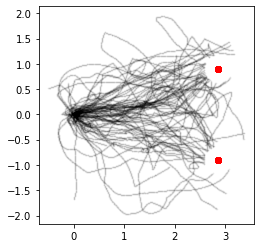

In [22]:
plt.scatter(tmp0['rotated_x'], tmp0['rotated_y'], c='black', s=1, alpha=0.05)
plt.scatter(tmp0['rotated_post0_x'], tmp0['rotated_post0_y'], c='red')
plt.scatter(tmp0['rotated_post1_x'], tmp0['rotated_post1_y'], c='red')
plt.axes().set_aspect('equal')
plt.show()

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


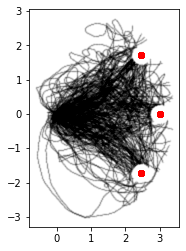

In [23]:
plt.scatter(tmp1['rotated_x'], tmp1['rotated_y'], c='black', s=1, alpha=0.05)
plt.scatter(tmp1['rotated_post0_x'], tmp1['rotated_post0_y'], c='red')
plt.scatter(tmp1['rotated_post1_x'], tmp1['rotated_post1_y'], c='red')
plt.scatter(tmp1['rotated_post2_x'], tmp1['rotated_post2_y'], c='red')
plt.axes().set_aspect('equal')
plt.show()

### Store trajectories from this database as x2s and y2s

In [24]:
if nPosts == 2:
    x2s = np.array(tmp0['rotated_x'])
    y2s = np.array(tmp0['rotated_y'])

    post0_x = np.unique(tmp0['rotated_post0_x'])[0]
    post0_y = np.unique(tmp0['rotated_post0_y'])[0]

    post1_x = np.unique(tmp0['rotated_post1_x'])[0]
    post1_y = np.unique(tmp0['rotated_post1_y'])[0]

else:
    x2s = np.array(tmp1['rotated_x'])
    y2s = np.array(tmp1['rotated_y'])

    post0_x = np.unique(tmp1['rotated_post0_x'])[0]
    post0_y = np.unique(tmp1['rotated_post0_y'])[0]

    post1_x = np.unique(tmp1['rotated_post1_x'])[0]
    post1_y = np.unique(tmp1['rotated_post1_y'])[0]

    post2_x = np.unique(tmp1['rotated_post2_x'])[0]
    post2_y = np.unique(tmp1['rotated_post2_y'])[0]

    x2s = np.concatenate((x2s, x2s))
    y2s = np.concatenate((y2s, -y2s))

### Merge results from both databases to xs and ys

In [25]:
xs = np.concatenate((x1s,x2s))
ys = np.concatenate((y1s,y2s))

In [26]:
nbins = 500
peak_threshold = 0.9


def density_map(x, y, stats=True):
    if nPosts == 2:
        val = 151

        blur = (11, 11) if stats == True else (val, val)
        r = (
            [[0, post0_x], [post0_y, post1_y]]
        )
    else:
        val = 105

        blur = (11, 11) if stats == True else (val, val)
        r = [[0, post1_x], [post0_y, post2_y]]
    h, xedge, yedge, image = plt.hist2d(x, y, bins=nbins, normed=True, range=r)

    if nPosts == 2:
        tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))
    else:
        tmp_img = np.flipud(np.rot90(cv2.GaussianBlur(h, blur, 0)))

    for i in range(0, nbins):
        max_val = np.max(tmp_img[:, i])
        tmp_img[:, i] = tmp_img[:, i] / max_val

    return tmp_img

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.


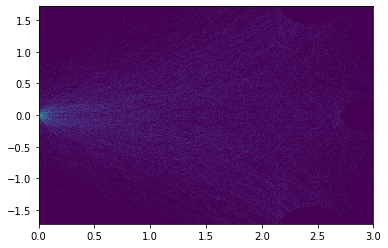

In [27]:
img = density_map(xs, ys, stats=False)

if nPosts == 2:
    x_peaks = np.where(img > peak_threshold)[1] * post0_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post1_y) / nbins + post1_y
else:
    x_peaks = np.where(img > peak_threshold)[1] * post1_x / nbins
    y_peaks = np.where(img > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y

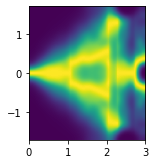

In [28]:
if nPosts == 2:
    fig, ax = plt.subplots(1, 1, figsize=(post0_x, post1_y*2))
    plt.imshow(img ** 2, extent=[0, post0_x, post0_y, post1_y])
    plt.xticks([0, 1, 2])
    plt.yticks([0])
else:
    fig, ax = plt.subplots(1, 1, figsize=(2.5, post2_x))
    plt.imshow(img ** 2, extent=[0, post1_x, post0_y, post2_y])
    plt.xticks([0, 1, 2, 3])
    
plt.savefig(
    "/mnt/ssd1/Documents/Vivek/locustVR/"
    + str(nPosts)
    + "_post_bifurcation_tracks.pdf",
    dpi=600,
    bbox_inches="tight",
)

In [29]:
def fitfunc(x, p, q, r):
    return r * (np.abs((x - p)) ** q)


def fitfunc_vec_self(x, p, q, r):
    y = np.zeros(x.shape)
    for i in range(len(y)):
        y[i] = fitfunc(x[i], p, q, r)
    return y

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


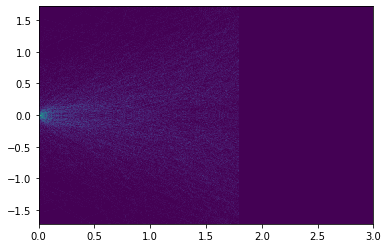

In [54]:
bif_pt = 0.7
params1 = [0.7, 1, 1]

xs1 = xs[np.where(xs < 1.8)[0]]
ys1 = ys[np.where(xs < 1.8)[0]]

x_fit = []
y_fit = []

x_sub = np.concatenate((xs1, xs1))
y_sub = np.concatenate((ys1, -ys1))

tmp_img = density_map(x_sub, y_sub, stats=True)
x_fit = np.where(tmp_img > peak_threshold)[1] * post1_x / nbins
y_fit = (
    np.where(tmp_img > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y
)

x_fit = x_fit
y_fit = np.abs(y_fit)
y_fit = y_fit[x_fit > bif_pt]
x_fit = x_fit[x_fit > bif_pt]

for i in range(0,10):
    fit_params, pcov = curve_fit(
        fitfunc_vec_self, x_fit, y_fit, p0=params1, maxfev=10000
    )
    params1 = fit_params

([<matplotlib.axis.XTick at 0x7f4f4ce47b38>,
 <a list of 3 Text xticklabel objects>)

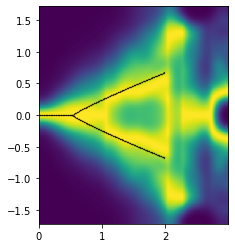

In [55]:
plt.imshow(img ** 2, extent=[0, post1_x, post0_y, post2_y])

parameters = params1
step_len = 0.01

x1 = np.arange(step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))

x = (
    np.arange(parameters[0], 2.0, step_len)
)
x2 = np.concatenate((x, x))
y2 = np.concatenate(
    (
        (parameters[2] * (x - parameters[0])) ** parameters[1],
        -(parameters[2] * (x - parameters[0])) ** parameters[1],
    )
)

if nPosts != 2:
    bisector_xs = [params1[0], post2_x]
    bisector_ys = [
        0,
        np.tan(np.arctan2(post2_y, post2_x - params1[0]) / 2)
        * (post2_x - params1[0]),
    ]

plt.scatter(x1, y1, c="black", s=0.1)
plt.scatter(x2, y2, c="black", s=0.1)
plt.xticks([0, 1, 2])

In [56]:
print("The first bifurcation occurs at an angle",2 * np.arctan2(post2_y, post2_x - params1[0]) * 180 / np.pi,)

The first bifurcation occurs at an angle 83.60325035885563


#### Get the second bifurcation point
For this, you must center the trajectories about the bifurcation point, get a new heatmap and rotate this by the angle of the bisector line

In [57]:
# center points about the first bifurcation
cxs = xs - params1[0]
cys = ys

cpost0_x = post0_x - params1[0]
cpost1_x = post1_x - params1[0]
cpost2_x = post2_x - params1[0]

In [58]:
@numba.njit(fastmath=True, parallel=True)
def parallel_rotate(xy, rmat):
    out = np.zeros(xy.shape)
    for idx in numba.prange(xy.shape[0]):
        out[idx] = np.dot(rmat[idx], xy[idx])
    return out

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.


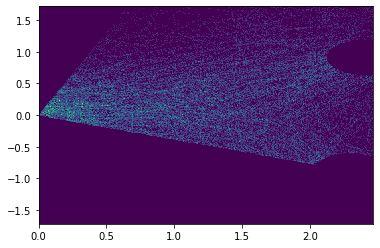

In [59]:
# clip all points to the left of and below 0 and points beyond post centers
ccxs = cxs[np.where(cxs > 0)[0]]
ccys = cys[np.where(cxs > 0)[0]]
ccxs = ccxs[np.where(ccys > 0)[0]]
ccys = ccys[np.where(ccys > 0)[0]]

xy = np.concatenate((ccxs.reshape(-1, 1), ccys.reshape(-1, 1)), axis=1)
angle = np.full(
    ccxs.shape, np.arctan2(post2_y, post2_x - params1[0]) / 2
)
rmat = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]).T
rx, ry = parallel_rotate(xy, rmat).T

blur = (101, 101)

r1 = [[0, post1_x], [post0_y, post2_y]]
r2 = [
    [-params1[0], post1_x - params1[0]],
    [post0_y, post2_y],
]
r3 = [[0, post1_x - params1[0]], [post0_y, post2_y]]

h1, xedge, yedge, image = plt.hist2d(xs, ys, bins=nbins, normed=True, range=r1)
h2, xedge, yedge, image = plt.hist2d(cxs, cys, bins=nbins, normed=True, range=r2)
h3, xedge, yedge, image = plt.hist2d(
    ccxs, ccys, bins=nbins, normed=True, range=r3
)
h4, xedge, yedge, image = plt.hist2d(rx, ry, bins=nbins, normed=True, range=r3)

tmp_img1 = np.flipud(np.rot90(cv2.GaussianBlur(h1, blur, 0)))
tmp_img2 = np.flipud(np.rot90(cv2.GaussianBlur(h2, blur, 0)))
tmp_img3 = np.flipud(np.rot90(cv2.GaussianBlur(h3, blur, 0)))
tmp_img4 = np.flipud(np.rot90(cv2.GaussianBlur(h4, blur, 0)))

for i in range(0, nbins):
    max_val = np.max(tmp_img1[:, i])
    tmp_img1[:, i] = tmp_img1[:, i] / max_val
    max_val = np.max(tmp_img2[:, i])
    tmp_img2[:, i] = tmp_img2[:, i] / max_val
    max_val = np.max(tmp_img3[:, i])
    tmp_img3[:, i] = tmp_img3[:, i] / max_val
    max_val = np.max(tmp_img4[:, i])
    tmp_img4[:, i] = tmp_img4[:, i] / max_val

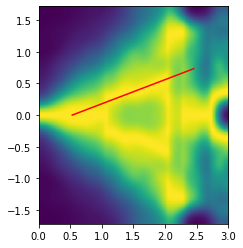

In [60]:
plt.imshow(tmp_img1, extent=[r1[0][0], r1[0][1], r1[1][0], r1[1][1]])
plt.plot(bisector_xs, bisector_ys, c="red")

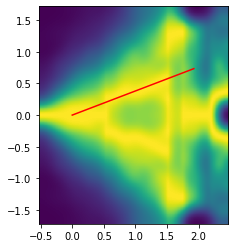

In [61]:
plt.imshow(tmp_img2, extent=[r2[0][0], r2[0][1], r2[1][0], r2[1][1]])
plt.plot(bisector_xs - params1[0], bisector_ys, c="red")

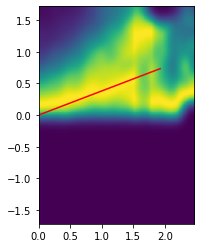

In [62]:
plt.imshow(np.flipud(tmp_img3), extent=[r3[0][0], r3[0][1], r3[1][0], r3[1][1]])
plt.plot(bisector_xs - params1[0], bisector_ys, c="red")

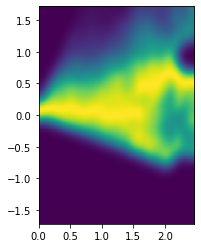

In [63]:
plt.imshow(np.flipud(tmp_img4), extent=[r3[0][0], r3[0][1], r3[1][0], r3[1][1]])

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: The 'normed' parameter of hist2d() has been renamed 'density' since Matplotlib 3.1; support for the old name will be dropped in 3.3.
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


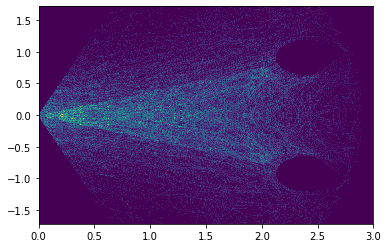

In [86]:
bif_pt = 1.2
params2 = [1.2, 0.5, 1]

x_fit = []
y_fit = []

x_sub = np.concatenate((rx, rx))
y_sub = np.concatenate((ry, -ry))

tmp_img = density_map(x_sub, y_sub, stats=True)
x_fit = np.where(tmp_img > peak_threshold)[1] * post1_x / nbins
y_fit = np.where(tmp_img > peak_threshold)[0] * (post0_y - post2_y) / nbins + post2_y

x_fit = x_fit
y_fit = np.abs(y_fit)
y_fit = y_fit[x_fit > bif_pt]
x_fit = x_fit[x_fit > bif_pt]

for i in range(0, 10):
    fit_params, pcov = curve_fit(
        fitfunc_vec_self, x_fit, y_fit, p0=params2, maxfev=10000
    )
    params2 = fit_params

In [87]:
params2

array([1.24239816, 0.32421943, 0.47786199])

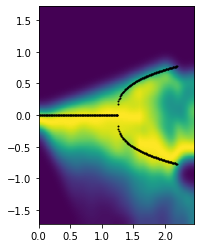

In [88]:
plt.imshow(tmp_img4, extent=[r3[0][0], r3[0][1], r3[1][0], r3[1][1]])

parameters = params2
step_len = 0.01

x1 = np.arange(step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))

x = np.arange(parameters[0], 2.2, step_len)
x2 = np.concatenate((x, x))
y2 = np.concatenate(
    (
        (parameters[2] * (x - parameters[0])) ** parameters[1],
        -(parameters[2] * (x - parameters[0])) ** parameters[1],
    )
)

plt.scatter(x1, y1, c="black", s=1)
plt.scatter(x2, y2, c="black", s=1)

In [89]:
bif2 = np.array([params2[0], 0]).reshape(1, -1)
ang = angle[0]
rmat1 = np.array([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]]).T
bif2 = parallel_rotate(bif2, rmat).T
bif2[0] += params1[0]

In [90]:
print(
    "The second bifurcation occurs at angle",
    (
        (
            np.arctan2(post2_y - bif2[1], post2_x - bif2[0])
            - np.arctan2(bif2[1] - post1_y, post1_x - bif2[0])
        )
        * 180
        / np.pi
    )[0],
)

The second bifurcation occurs at angle 89.30121896119225


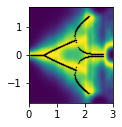

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(post1_x/2, post2_x))
plt.imshow(img ** 2, extent=[0, post1_x, post0_y, post2_y])

parameters = params2
step_len = 0.01

x1 = np.arange(step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))
bcxy1 = np.concatenate((x1.reshape(-1, 1), y1.reshape(-1, 1)), axis=1)
ang1 = np.full(x1.shape, -np.arctan2(post2_y, post2_x - params1[0]) / 2)
rmat1 = np.array([[np.cos(ang1), -np.sin(ang1)], [np.sin(ang1), np.cos(ang1)]]).T
bcx1, bcy1 = parallel_rotate(bcxy1, rmat1).T
bx1 = bcx1 + params1[0]

x = np.arange(parameters[0], 2., step_len)
x2 = np.concatenate((x, x))
y2 = np.concatenate(
    (
        (parameters[2] * (x - parameters[0])) ** parameters[1],
        -(parameters[2] * (x - parameters[0])) ** parameters[1],
    )
)
bcxy2 = np.concatenate((x2.reshape(-1, 1), y2.reshape(-1, 1)), axis=1)
ang2 = np.full(x2.shape, -np.arctan2(post2_y, post2_x - params1[0]) / 2)
rmat2 = np.array([[np.cos(ang2), -np.sin(ang2)], [np.sin(ang2), np.cos(ang2)]]).T
bcx2, bcy2 = parallel_rotate(bcxy2, rmat2).T
bx2 = bcx2 + params1[0]

bx2 = np.concatenate((bx2, bx2))
bcy2 = np.concatenate((bcy2, -bcy2))

plt.scatter(bx2, bcy2, c="black", s=0.1)

parameters = params1
step_len = 0.01

x1 = np.arange(5 * step_len, parameters[0], step_len)
y1 = np.zeros(len(x1))

x = np.arange(parameters[0], np.max(bx1), step_len)
x2 = np.concatenate((x, x))
y2 = np.concatenate(
    (
        (parameters[2] * (x - parameters[0])) ** parameters[1],
        -(parameters[2] * (x - parameters[0])) ** parameters[1],
    )
)

plt.scatter(x1, y1, c="black", s=0.1)
plt.scatter(x2, y2, c="black", s=0.1)
plt.xticks([0, 1, 2, 3])
plt.yticks([-1, 0, 1])

fig.savefig(
    "/mnt/ssd1/Documents/Vivek/locustVR/"
    + str(nPosts)
    + "_post_bifurcation_quantified.pdf",
    dpi=300,
    bbox_inches="tight",
)